In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e10/sample_submission.csv
/kaggle/input/playground-series-s5e10/train.csv
/kaggle/input/playground-series-s5e10/test.csv


**Accident Risk Prediction with Custom Feature Importance & Error-Aware Stacking**

This project aims to predict accident risk using road, weather, and temporal features. Unlike typical approaches, it emphasizes:



*   Deep exploratory analysis
*   Feature-wise predictive power evaluation
*   A custom stacking model that learns from prediction errors





# 📊 Step 1: Initial Data Inspection

In [2]:
# Core libraries for numerical operations and data manipulation
import numpy as np
import pandas as pd

# Utility for splitting data into training and validation sets
from sklearn.model_selection import train_test_split

# Visualization libraries for exploratory data analysis
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing tools for encoding and scaling features
from sklearn.preprocessing import OneHotEncoder, StandardScaler, _function_transformer, OrdinalEncoder, MinMaxScaler

# Pipeline and column-wise transformation utilities for clean preprocessing workflows
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Feature selection using sequential search (forward or backward)
from sklearn.feature_selection import SequentialFeatureSelector as sfs

# Gradient boosting model from XGBoost — powerful for tabular regression tasks
from xgboost import XGBRegressor

# Evaluation metric: Mean Absolute Error (MAE) for regression performance
from sklearn.metrics import mean_absolute_error , r2_score

# Ensemble model: Random Forest Regressor for baseline or comparison
from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor

from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression

In [4]:
# Load training data from CSV file
data = pd.read_csv("/kaggle/input/playground-series-s5e10/train.csv")

# Drop the 'id' column as it's not informative for modeling
data = data.drop("id", axis=1)

# Display the dataset to verify successful loading and structure
data

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...
517749,highway,4,0.10,70,daylight,foggy,True,True,afternoon,False,False,2,0.32
517750,rural,4,0.47,35,daylight,rainy,True,True,morning,False,False,1,0.26
517751,urban,4,0.62,25,daylight,foggy,False,False,afternoon,False,True,0,0.19
517752,highway,3,0.63,25,night,clear,True,False,afternoon,True,True,3,0.51


In [ ]:
# Display dataset structure, data types, and non-null counts
print("Data Info:\n")
print(data.info())

# Show the number of missing values per feature
print("\nMissing Values per Feature:\n")
print(data.isna().sum())

Data Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   road_type               517754 non-null  object 
 1   num_lanes               517754 non-null  int64  
 2   curvature               517754 non-null  float64
 3   speed_limit             517754 non-null  int64  
 4   lighting                517754 non-null  object 
 5   weather                 517754 non-null  object 
 6   road_signs_present      517754 non-null  bool   
 7   public_road             517754 non-null  bool   
 8   time_of_day             517754 non-null  object 
 9   holiday                 517754 non-null  bool   
 10  school_season           517754 non-null  bool   
 11  num_reported_accidents  517754 non-null  int64  
 12  accident_risk           517754 non-null  float64
dtypes: bool(4), float64(2), int64(3), object(4)
memory usage: 37.5

# 🔍 Step 2: Exploratory Data Analysis (EDA)

<Axes: >

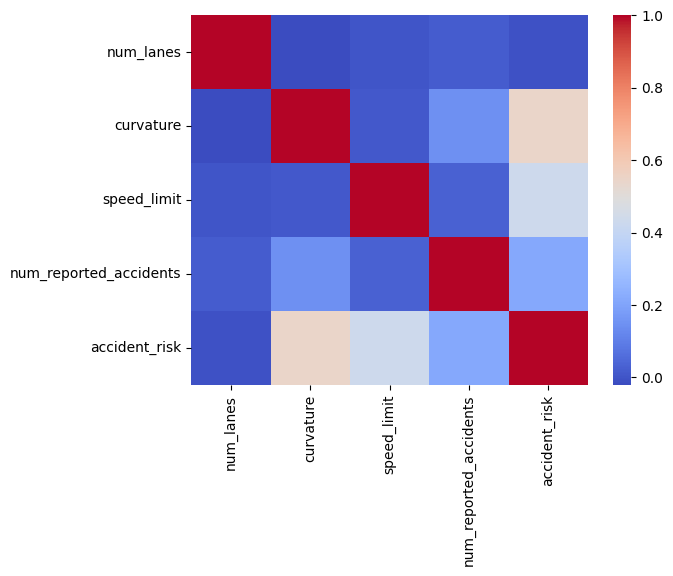

In [ ]:
# Compute the correlation matrix for all numerical features
# Visualize feature relationships using a heatmap to identify potential multicollinearity or predictive patterns

corr = data.select_dtypes(["number"]).corr()
sns.heatmap(corr , cmap='coolwarm')

<Axes: xlabel='weather', ylabel='num_reported_accidents'>

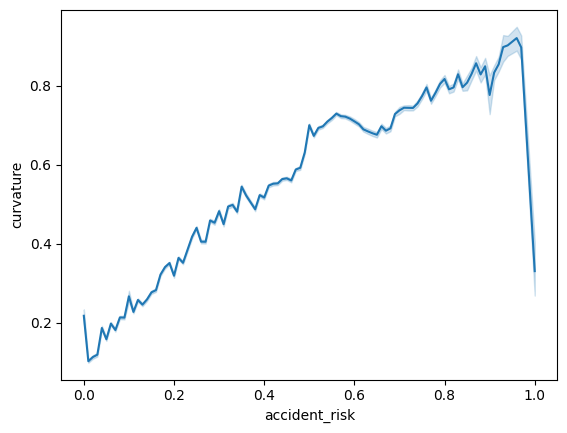

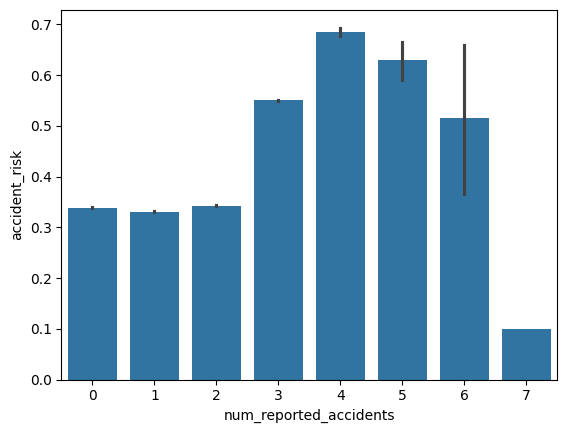

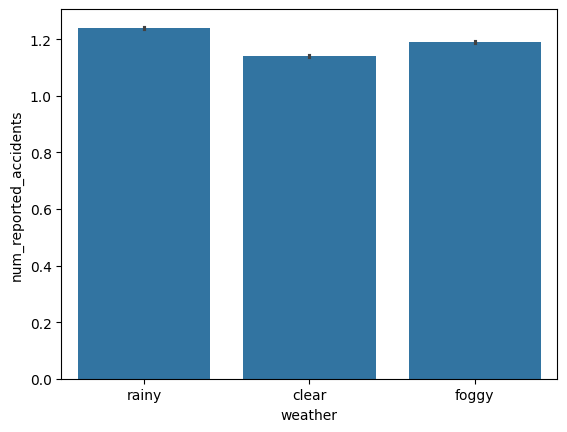

In [ ]:
# Visualize the relationship between accident risk and road curvature
plt.figure()
sns.lineplot(x='accident_risk', y='curvature', data=data)

# Explore how the number of reported accidents correlates with accident risk
plt.figure()
sns.barplot(x='num_reported_accidents', y='accident_risk', data=data)

# Examine the impact of weather conditions on the number of reported accidents
plt.figure()
sns.barplot(x='weather', y='num_reported_accidents', data=data)

<Axes: xlabel='lighting', ylabel='accident_risk'>

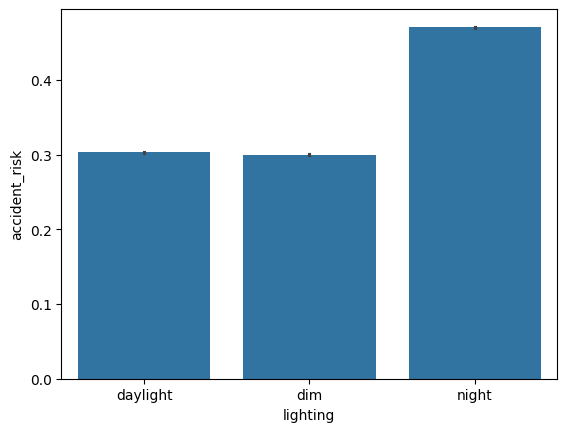

In [ ]:
# Analyze how lighting conditions influence accident risk
sns.barplot(x='lighting', y='accident_risk', data=data)

<Axes: xlabel='lighting', ylabel='num_reported_accidents'>

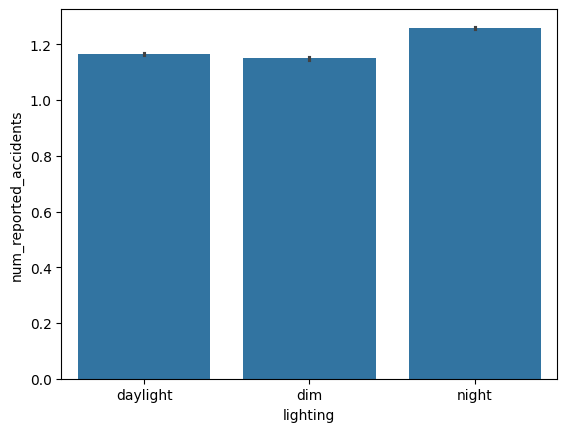

In [ ]:
sns.barplot(x = 'lighting' , y='num_reported_accidents' , data = data)

🔍 Initial Data Inspection
- Loaded the dataset from train.csv.
- Dropped the id column as it holds no predictive value.
- Reviewed the dataset structure and checked for missing values per feature.


📈 Feature Relationships


- Visualized the relationship between accident_risk and curvature using a line plot.
- Analyzed how num_reported_accidents correlates with accident risk.
- Investigated the impact of weather conditions on accident frequency.
- Assessed the influence of lighting conditions on accident risk via bar plots.

🧠 Key Takeaways

- Features like weather and lighting may carry strong predictive signals.
- Non-linear patterns are visible between certain features and the target variable.
- Further preprocessing is needed, including scaling and encoding.



In [ ]:
data_target = data['accident_risk']

# Split data into training and validation sets (80/20 split)
train_data, validate_data, y_train, y_validate = train_test_split(
    data.drop('accident_risk', axis=1),
    data_target,
    train_size=0.8,
    random_state=42,
    stratify=data_target
)


# 🧮 Step 3: Custom Feature Importance Function

### 🧠 Feature Importance Function

This custom function evaluates the predictive power of each feature individually by:
- Selecting features by data type (categorical, boolean, numeric)
- Applying appropriate preprocessing (e.g., OneHotEncoding, Scaling)
- Training a model (XGBoost or Random Forest) on each feature separately
- Measuring performance using Mean Absolute Error (MAE)

Lower MAE indicates higher predictive value of the feature.

This approach helps identify which features contribute most to the target variable and guides feature selection for downstream modeling.


In [ ]:
def feature_importance( X  , X_val , y  , y_val ,model = 'xgboost' ):
  # Identify unique data types in the dataset (e.g., object, bool, numeric)
  type_ = (X.dtypes).unique()
  feature_impact = []
  # Helper function to preprocess, train, and evaluate a single feature
  def train_valid(transformer ,train , valid_data , feature_ , type_data , y_val_):
    # Apply preprocessing pipeline to training and validation data
      train = transformer.fit_transform(train)
      valid = transformer.transform(valid_data)
      # Train XGBoost model on the transformed feature
      feature_model = XGBRegressor(n_estimators=1000, learning_rate=0.05)
      feature_model.fit(train , y)
      # Predict and evaluate using Mean Absolute Error
      predict = feature_model.predict(valid)
      mse = mean_absolute_error( predict, y_val_)
       # Store feature name and its corresponding MAE
      feature_impact.append((feature_ , mse , type_data))
      return feature_impact
  # Helper function to build preprocessing pipeline based on feature type
  def data_piplines(data_type_ = 'int64'):
    if data_type_ == 'O':
      # For categorical features: encode using Ordinal + OneHot
      pip = Pipeline([
          ("ordinal" , OrdinalEncoder()),
          ("ohe" , OneHotEncoder())
      ])

    elif data_type_ == 'bool' :
      pip = Pipeline([
          ("ordinal" , OrdinalEncoder())
      ])
    # For boolean features: encode using OrdinalEncoder
    elif data_type_ in ['int64' , 'float64'] :
      # For numeric features: scale using StandardScaler
      pip = Pipeline([
          ("scaler" , StandardScaler())
      ])
    return pip
  # Loop through each data type and evaluate feature importance
  for data_type in type_:
    # Select features of the current data type
    data_train = X.select_dtypes([data_type])
    data_validate = X_val.select_dtypes([data_type])
    data_col = (data_train.columns).tolist()

    if model == 'xgboost':
      for feature in data_col:
        # Build appropriate pipeline and transformer for the feature
        if data_type == 'O':
          pip = data_piplines(data_type)
          # Train and evaluate the feature
          transformer = ColumnTransformer([('onehot', pip, [feature])], remainder='drop')
          train_valid(transformer , train = data_train ,valid_data= data_validate , feature_=feature , type_data=data_type , y_val_=y_val)

        elif data_type == 'bool' :
          pip = data_piplines(data_type)
          transformer = ColumnTransformer([
              ('onehot', pip, [feature])
              ], remainder='drop')

          train_valid(transformer , train = data_train ,valid_data= data_validate , feature_=feature , type_data=data_type , y_val_=y_val)

        elif data_type == 'int64' or data_type == 'float64' :
          pip = data_piplines(data_type)
          transformer = ColumnTransformer([
              ('onehot', pip, [feature])
              ], remainder='drop')
          train_valid(transformer , train = data_train ,valid_data= data_validate , feature_=feature , type_data=data_type , y_val_=y_val)


    elif model == 'random_forest':
      for feature in data_col:
        feature_model = RandomForestRegressor(n_estimators=1000, random_state=42)
        feature_model.fit(data_train[feature] , y)
        feature_impact.append((feature , mean_absolute_error(feature_model.predict(valid) , y_val)))
  feature_importance = pd.DataFrame(feature_impact , columns=['col' , 'mse' , 'type'])
  return feature_importance.sort_values(by='mse')




In [ ]:
# Evaluate feature importance using custom function
# This function trains a model on each feature individually and computes its MAE on validation data
# Lower MAE indicates higher predictive value for the target variable (accident_risk)
f_impact = feature_importance(X = train_data, X_val = validate_data, y_val = y_validate, y = y_train)

# Display the resulting DataFrame showing each feature's name, MAE score, and data type
f_impact


,col,mse,type
3,curvature,0.112299,float64
4,speed_limit,0.117219,int64
1,lighting,0.119422,object
5,num_reported_accidents,0.124281,int64
2,weather,0.130981,object
7,holiday,0.132632,bool
6,public_road,0.132793,bool
0,road_type,0.132839,object
8,school_season,0.132894,bool


<Axes: xlabel='col', ylabel='mse'>

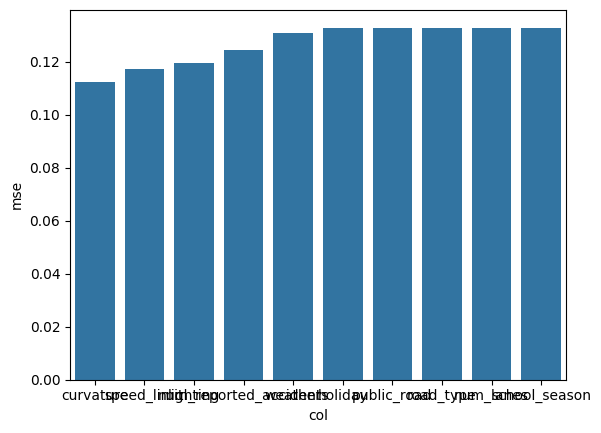

In [ ]:
# Visualize feature importance scores using a bar plot
# Each bar represents a feature, and its height corresponds to the MAE (lower is better)
sns.barplot(x = f_impact['col'], y = f_impact['mse'])


In [ ]:
# Drop selected features from the training dataset
# These features may be redundant, low-impact, or removed based on prior analysis
train_data = train_data.drop(['road_signs_present', 'time_of_day', 'num_lanes'], axis=1)


In [ ]:
f_impact = feature_importance(X = train_data, X_val = validate_data, y_val = y_validate, y = y_train)
f_impact

# 🧼 Step 4: Feature Preprocessing Pipeline

In [ ]:
# Build a ColumnTransformer to apply appropriate preprocessing to each feature type
transformer = ColumnTransformer([
    # Apply OneHotEncoder to categorical features (type: object)
    ("ohe", OneHotEncoder(), f_impact[f_impact['type'] == 'object']['col'].tolist()),

    # Apply MinMaxScaler to numerical features (type: int64 or float64)
    ("scaler", MinMaxScaler(), f_impact[(f_impact['type'] == 'int64') | (f_impact['type'] == 'float64')]['col'].tolist()),

    # Apply OrdinalEncoder to boolean features (type: bool)
    ("ordinal", OrdinalEncoder(), f_impact[f_impact['type'] == 'bool']['col'].tolist())
], remainder="passthrough")  # Leave all other columns unchanged

In [ ]:
# Fit the transformer on training data and apply transformations
train = transformer.fit_transform(train_data)

# Convert the transformed training data to a DataFrame with proper column names
train = pd.DataFrame(train, columns=transformer.get_feature_names_out())

# Apply the same transformation to validation data
validate = transformer.transform(validate_data)

# Convert the transformed validation data to a DataFrame with matching column names
validate = pd.DataFrame(validate, columns=transformer.get_feature_names_out())

# **Modeling**

# 🧠 Step 5: Error-Aware Stacking Model

### 🔁 Custom Stacking Model: `StackErorModel`

This class implements a custom stacking strategy for regression tasks by learning from **prediction errors across multiple cross-validation folds**. Instead of stacking raw predictions, it builds a second-level model using the **absolute error and predicted values** from a base model — allowing it to capture residual patterns and improve generalization.

#### 📦 Key Features:
- Supports **CatBoost**, **XGBoost**, and **Linear Regression** as base learners.
- Uses **cross-validation** to generate error-based features for stacking.
- Trains a **final CatBoost model** on error features to refine predictions.
- Automatically saves intermediate models (`model0.cbm`, `model1.cbm`, ...) for reproducibility and incremental training.

#### 🧠 Why It Works:
Traditional stacking combines predictions from multiple models. This approach goes further by:
- Measuring how each fold's model performs on unseen data.
- Capturing **where and how the model fails** (via absolute error).
- Training a meta-model to correct those failures using error patterns.

#### 🛠️ Usage:
```python
stack_model = StackErorModel(
    data=X_train,
    target=y_train,
    test=X_test,
    test_target=y_test,
    model='catboost',
    cv=3
)

stack_model.fit(None)
final_model, test_features, test_targets = stack_model.transform(None)


In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

# Custom stacking model that learns from prediction errors across multiple folds
# Designed for regression tasks with support for CatBoost, XGBoost, and Linear Regression
class StackErorModel(BaseEstimator, TransformerMixin):

    def __init__(self, data, target, test, test_target, model='catboost', cv=3) -> None:
        # Store training and test data
        self.data = data
        self.target = target
        self.test = test
        self.test_target = test_target
        self.cv = cv  # Number of cross-validation folds

        # Initialize containers for cross-validation splits and final training data
        self.cv_data = []
        self.fainal_data = pd.DataFrame()
        self.fainal_target = pd.DataFrame()
        self.fainal_test_data = pd.DataFrame()
        self.fainal_test_target = pd.DataFrame()

        # Select base model based on user input
        if model == 'LinearRegression':
            self.model = LinearRegression()
        elif model == 'XGBoost':
            self.model = XGBRegressor(n_estimators=1000, learning_rate=0.05)
        elif model == 'catboost':
            # Base CatBoost model for fold-level training
            self.model = CatBoostRegressor(
                task_type="GPU",
                iterations=1500,
                learning_rate=0.07,
                depth=10,
                verbose=100,
                loss_function='RMSE',
                random_strength=5,
                l2_leaf_reg=10
            )
            # Final CatBoost model trained on error-based features
            self.fainal_model = CatBoostRegressor(
                iterations=1500,
                learning_rate=0.8,
                depth=9,
                verbose=100,
                loss_function='RMSE',
                random_strength=5,
                l2_leaf_reg=10
            )

    def fit(self, x, y=None):
        # Perform cross-validation and collect prediction errors
        for i in range(self.cv):
            train, valid, y_train, y_valid = train_test_split(
                self.data, self.target, test_size=0.2, random_state=i
            )
            valid = valid.reset_index(drop=True)
            y_valid = y_valid.reset_index(drop=True)
            self.cv_data.append((train, valid, y_train, y_valid))

        count = 0
        for train, valid, y_train, y_valid in self.cv_data:
            # Train base model and predict on validation fold
            self.model.fit(train, y_train)
            prediction = self.model.predict(valid)

            # Compute absolute error and store predictions
            absolute_error = np.abs(np.array(prediction) - np.array(y_valid))
            self.fainal_data["absolute_error"] = absolute_error
            self.fainal_data["prediction"] = prediction
            self.fainal_target["target"] = y_valid

            # On first fold, also evaluate on test set
            if count == 0:
                self.test = self.test.reset_index(drop=True)
                self.target = self.target.reset_index(drop=True)
                test_pred = self.model.predict(self.test)
                test_absolute_error = np.abs(np.array(test_pred) - np.array(self.test_target))
                self.fainal_test_data["absolute_error"] = test_absolute_error
                self.fainal_test_data["prediction"] = test_pred
                self.fainal_test_target["target"] = self.test_target

                # Train final model on error-based features
                self.fainal_model.fit(self.fainal_data, self.fainal_target)
                self.fainal_model.save_model(f'model{count}.cbm')
            else:
                # Continue training final model using previous iteration as init_model
                self.fainal_model.fit(
                    self.fainal_data, self.fainal_target, init_model=f'model{count-1}.cbm'
                )
                self.fainal_model.save_model(f'model{count}.cbm')

            count += 1

        return self

    def transform(self, x, y=None):
        # Return final model and test predictions with error features
        return self.fainal_model, self.fainal_test_data, self.fainal_test_target


In [ ]:
stack_model = StackErorModel(data=train , target=y_train , test = validate , test_target=y_validate , model='catboost' , cv=3)
model , test , target= stack_model.fit_transform(train)

0:	learn: 0.1564091	total: 16.4ms	remaining: 24.6s
100:	learn: 0.0560934	total: 2.56s	remaining: 35.4s
200:	learn: 0.0557758	total: 3.38s	remaining: 21.9s
300:	learn: 0.0554391	total: 4.27s	remaining: 17s
400:	learn: 0.0551637	total: 5.15s	remaining: 14.1s
500:	learn: 0.0549318	total: 6.04s	remaining: 12.1s
600:	learn: 0.0547068	total: 6.96s	remaining: 10.4s
700:	learn: 0.0545002	total: 7.88s	remaining: 8.98s
800:	learn: 0.0543201	total: 8.8s	remaining: 7.68s
900:	learn: 0.0541411	total: 9.71s	remaining: 6.46s
1000:	learn: 0.0539636	total: 10.6s	remaining: 5.3s
1100:	learn: 0.0537960	total: 11.6s	remaining: 4.19s
1200:	learn: 0.0536434	total: 12.7s	remaining: 3.15s
1300:	learn: 0.0534955	total: 14.9s	remaining: 2.28s
1400:	learn: 0.0533495	total: 15.9s	remaining: 1.12s
1499:	learn: 0.0532165	total: 16.8s	remaining: 0us
0:	learn: 0.0764035	total: 16.2ms	remaining: 24.3s
100:	learn: 0.0505708	total: 1.24s	remaining: 17.2s
200:	learn: 0.0471682	total: 2.47s	remaining: 16s
300:	learn: 0.04

# 📈 Step 6: Final Evaluation

In [ ]:
# Generate predictions on the test set using the final model
pered = model.predict(test)

# Evaluate model performance using Mean Absolute Error (MAE)
print(mean_absolute_error(target, pered))  # Lower MAE indicates better accuracy

# Compute R² score to assess goodness of fit
print(r2_score(target, pered))  # Closer to 1 means better explanatory power


0.019906483849349572
0.9331259077950371


🎯 Extremely low MAE and high R² indicate strong predictive performance and reliability.